# Dev notebook for updates

`Lanczos optimization`

In [24]:
import numpy as np
from dmrg_src.MPS import MPS 
from dmrg_src.MPO import MPO_TFI
from dmrg_src.cont import CONT
from dmrg_src.dmrg import dmrg
from dmrg.obs import observables

import matplotlib.pyplot as plt
import os
import shutil
from tqdm import tqdm

### Class 

In [ ]:
import numpy as np
from scipy.linalg import eigh_tridiagonal
from scipy.sparse.linalg import ArpackNoConvergence


class EffH():

    def __init__(self,L,R,H,site,k=300):
        self.L = L 
        self.R = R 
        self.H = H 
        self.k = k
        self.d = H.d
        self.site = site
        c1,_,_ = L.shape
        c2,_,_ = R.shape
        self.c1 = c1
        self.c2 = c2
        self.len_vec = c1*c2*self.d**2
        self.k = min(c1*c2*self.d**2,k)

    def __str__(self):
        return 'Effective Hamiltonian on the Cayley tree'
    
    def __repr__(self):
        return 'Effective Hamiltonian on the Cayley tree'

    def matvec(self,psi):
        h = self.H
        psi = np.reshape(psi,(self.c1,self.d,self.d,self.c2))
        
        x = np.tensordot(self.L,h.mpo(p=self.site),(1,2))
        x = np.tensordot(x,psi,[(0,2),(0,1)])
        x = np.tensordot(x,h.mpo(p=self.site+1),[(2,3),(2,0)])
        x = np.tensordot(x,self.R,[(4,2),(1,0)])
        
        return np.reshape(x,(self.c1*self.d*self.d*self.c2))
    
    def lanc_iter(self,psi0,exc='off'):
        psi0 = psi0/np.linalg.norm(psi0)
        vecs = [psi0] 

        T = np.zeros((self.k,self.k))
        
        psi = self.matvec(psi0)
        alpha = T[0, 0] = np.inner(psi0.conj(),psi).real
        psi = psi - alpha* vecs[-1]
        
        for i in range(1,self.k):
            beta = np.linalg.norm(psi)
            if beta  < 1e-8:
                T = T[:i, :i]
                break
            if exc == 'off':
                psi /= beta
            if exc == 'on':
                psi_o = psi
                for j in range(i):
                    psi_o -= (psi.conj()@vecs[j])*vecs[j]
                psi = psi_o/np.linalg.norm(psi_o)
            vecs.append(psi)
            psi = self.matvec(psi) - beta*vecs[-2]
            alpha = psi.conj()@vecs[-1]
            psi = psi - alpha * vecs[-1] 
            T[i, i] = alpha.real
            T[i-1, i] = T[i, i-1] = beta    
        
        return T, (np.array(vecs).T).conj()

    def lanc_iter_old(self,psi0,exc='off'):
        psi0 = psi0/np.linalg.norm(psi0)
        vecs = [psi0] 

        T = np.zeros((self.k,self.k))
        
        psi = self.matvec(psi0)
        alpha = T[0, 0] = np.inner(psi0.conj(),psi).real
        psi = psi - alpha* vecs[-1]
        
        for i in range(1,self.k):
            beta = np.linalg.norm(psi)
            if beta  < 1e-8:
                T = T[:i, :i]
                break
            if exc == 'off':
                psi /= beta
            if exc == 'on':
                psi_o = psi
                for j in range(i):
                    psi_o -= (psi.conj()@vecs[j])*vecs[j]
                psi = psi_o/np.linalg.norm(psi_o)
            vecs.append(psi)
            psi = self.matvec(psi) 
            alpha = np.inner(vecs[-1].conj(), psi).real
            psi = psi - alpha * vecs[-1] - beta * vecs[-2]
            T[i, i] = alpha
            T[i-1, i] = T[i, i-1] = beta    
        return T, np.array(vecs).T

    def lanc_iter_new(self,psi0,exc='off'):
        psi0 = psi0/np.linalg.norm(psi0)
        vecs = [psi0] 

        T = np.zeros((self.k,self.k))
        
        psi = self.matvec(psi0)
        alpha = T[0, 0] = np.inner(psi0.conj(),psi).real
        psi = psi - alpha* vecs[-1]
        
        for i in range(1,self.k):
            beta = np.linalg.norm(psi)
            if np.abs(beta)  < 1e-8:
                T = T[:i, :i]
                break
            if exc == 'off':
                psi /= beta
            if exc == 'on':
                psi_o = psi
                for j in range(i):
                    psi_o -= (psi.conj()@vecs[j])*vecs[j]
                psi = psi_o/np.linalg.norm(psi_o)
            vecs.append(psi)
            psi = self.matvec(psi) 
            alpha = np.inner(vecs[-1].conj(), psi).real
            psi = psi - alpha * vecs[-1] - beta * vecs[-2]
            T[i, i] = alpha
            T[i-1, i] = T[i, i-1] = beta    
        return T, np.array(vecs).T

    def lanczos_grd(self,psi0=None,exc='off'):
        if psi0 is None:
            psi0 = np.random.rand(self.c1*self.c2*self.d**2)
        T, vecs = self.lanc_iter_old(psi0,exc=exc)

        try:
            E,v = eigh_tridiagonal(np.diag(T),np.diag(T,k=1),select='i',select_range=(0,2))
            # E,v = np.linalg.eigh(T)
            result = vecs @ v[:, np.argmin(E)]
            if exc == 'off':
                E = min(E)
                
        except ArpackNoConvergence as err:
            print('Lanczos did not converge !!!')
            E = psi0.conj()@self.matvec(psi0)
            result = psi0

        return E, result

In [ ]:
import numpy as np
from scipy.linalg import svd

from dmrg.MPS import MPS
from dmrg.cont import CONT
# from .lanczos import EffH

class dmrg():
    """
        Class that runs the DMRG algorithm on a 1 dimensional system

            Attributes:
                - cont: Class DMRG.contractions
    """

    def __init__(self,cont,chi=100,cut=1e-12,k=100):
        self.cont = cont
        self.mps = cont.mps
        self.chi = chi
        self.h = cont.h
        self.L = cont.L
        self.count = cont.count
        self.cut = cut
        self.d = self.mps.d
        self.k = k

    
    def infinite(self):

        En = np.zeros(self.L//2-1)
        
        env_left = self.cont.left(self.L%2)
        env_right = self.cont.right(self.L-1)

        for i in range(1,self.mps.L//2):

            H = EffH(env_left,env_right,self.h,site=i)
            En[i-1],grd = H.lanczos_grd()

            mat = np.reshape(grd,(H.c1*H.d,H.d*H.c2))
            l,c,r = svd(mat,full_matrices=False)

            bound = min(len(c[c>self.cut]),self.chi)
           
            l = l[:,:bound]
            c = c[:bound]
            r = r[:bound,:]

            self.mps.write_left(i+self.L%2,l)
            self.mps.write_right(self.mps.L-i-1,r)
        
            env_left = self.cont.add(i+self.L%2,'l')
            env_right = self.cont.add(self.mps.L-i-1,'r')
            
        self.mps.writeS(i+self.L%2,np.diag(c))

        return En

    def step2sites(self,site,dir,exc='off',stage=None):

        env_left,env_right = self.cont.env_prep(site)
    
        H = EffH(env_left,env_right,self.h,site=site,k=self.k)

        if dir == 'l' or dir == 'bl':
            init_vec = np.tensordot(self.mps.read(site),np.tensordot(self.mps.read(site+1),self.mps.readS(site+1),(2,0)),(2,1))
            init_vec = dmrg.remish(init_vec)
        if dir == 'r' or dir == 'br':
            init_vec = np.tensordot(np.tensordot(self.mps.readS(site-1),self.mps.read(site),(0,1)),self.mps.read(site+1),(2,1))

        init_vec = np.reshape(init_vec,np.prod(init_vec.shape))

        grd_pre = 1/np.sqrt(init_vec@np.conj(init_vec))*init_vec
        En_pre = np.conj(grd_pre)@H.matvec(grd_pre)
        
        if stage == None:
            En,grd = H.lanczos_grd(psi0=None,exc=exc)
            grd_state = 1/np.sqrt(np.conj(grd)@grd)*grd
            
        if stage == 'Final':
            grd_state = 1/np.sqrt(init_vec@np.conj(init_vec))*init_vec
            En = np.conj(grd_state)@H.matvec(grd_state)

        grd_state = np.reshape(grd_state,(H.c1*H.d,H.d*H.c2))

        l,c,r = svd(grd_state,full_matrices=False)
        
        bound = min(len(c[c**2>self.cut]),self.chi)
        l = l[:,:bound]
        c = c[:bound]
        r = r[:bound,:]
        
        self.mps.write_left(site,l)
        self.mps.write_right(site+1,r)
        self.mps.writeS(site,np.diag(c))

        if dir == 'r':
            self.cont.add(site,'l')
            if site == self.L -3:
                self.cont.add(site+1,'r')
        
        if dir == 'l':
            self.cont.add(site+1,'r')
            if site == 1:
                self.cont.add(site,'l')
        
        return En, -c**2@np.log(c**2)


    def remish(ten):
        d0,d1,d2,d3 = ten.shape
        res = np.zeros((d1,d0,d2,d3),dtype='complex256')
        for i0 in range(d0):
            for i1 in range(d1):
                res[i1,i0,:,:] = ten[i0,i1,:,:]

        return res
    

### MPO

In [ ]:
class MPO_AL():

    Id2 = np.identity(2)
    Id4 = np.identity(4)
    Sp = np.array([[0,1],[0,0]])
    Sm = np.array([[0,0],[1,0]])
    Z = np.array([[1,0],[0,-1]])
    d = 4

    sub_BC = [0,2,3]
    sub_A = [1,4]

    def __init__(self,t_1,t_2,U,e_A,mu):
        self.t_1 = t_1
        self.t_2 = t_2
        self.U = U
        self.e_A = e_A
        self.mu = mu
        self.OP = [np.kron(MPO_AL.Sm,MPO_AL.Id2),np.kron(MPO_AL.Sp,MPO_AL.Id2),np.kron(MPO_AL.Z,MPO_AL.Sm),np.kron(MPO_AL.Z,MPO_AL.Sp)]
        self.coeff = [[self.t_1,self.t_2,self.t_2,0,0],
                    [self.t_1,self.t_2,self.t_1,0,self.t_2],
                    [0,self.t_2,self.t_1,0,self.t_2],
                    [0,self.t_1,self.t_2,0,self.t_2],
                    [0,self.t_1,0,0,self.t_2]]

    
    def mpo(self,p):

        MPO = np.zeros((4,4,22,22))

        MPO[:,:,0,0] = MPO_AL.Id4
        MPO[:,:,0,1] = np.kron(MPO_AL.Sp,MPO_AL.Z)
        MPO[:,:,0,6] = np.kron(MPO_AL.Sm,MPO_AL.Z)
        MPO[:,:,0,11] = np.kron(MPO_AL.Id2,MPO_AL.Sp)
        MPO[:,:,0,16] = np.kron(MPO_AL.Id2,MPO_AL.Sm)
        MPO[:,:,0,21] = -self.mu*(np.kron(MPO_AL.Z,MPO_AL.Id2) + np.kron(MPO_AL.Id2,MPO_AL.Z))

        # sublattice conditions
        if (p-1)%5 in MPO_AL.sub_BC:
            MPO[:,:,0,21] += self.U*np.kron(MPO_AL.Z,MPO_AL.Z)
        
        if (p-1)%5 in MPO_AL.sub_A:
            MPO[:,:,0,21] += self.e_A*(np.kron(MPO_AL.Z,MPO_AL.Id2) + np.kron(MPO_AL.Id2,MPO_AL.Z))

        for j in range(4):
            for i in range(4):
                MPO[:,:,1 +j*5 +i,2+j*5+i] = np.kron(MPO_AL.Z,MPO_AL.Z)

        
        for j in range(1,6):
            for i in range(4):
                MPO[:,:,j+5*i,21] = self.coeff[(p-1)%5][j-1]*self.OP[i]

        MPO[:,:,21,21] = MPO_AL.Id4

        return MPO

    def Wl(self):

        Wleft = np.zeros((4,4,22))

        Wleft[:,:,0] = MPO_AL.Id4
        Wleft[:,:,1] = np.kron(MPO_AL.Sp,MPO_AL.Z)
        Wleft[:,:,6] = np.kron(MPO_AL.Sm,MPO_AL.Z)
        Wleft[:,:,11] = np.kron(MPO_AL.Id2,MPO_AL.Sp)
        Wleft[:,:,16] = np.kron(MPO_AL.Id2,MPO_AL.Sm)
        Wleft[:,:,21] = (-self.mu + self.e_A )*(np.kron(MPO_AL.Z,MPO_AL.Id2) + np.kron(MPO_AL.Id2,MPO_AL.Z)) 

        return Wleft

    def Wr(self):

        Wright = np.zeros((4,4,22))

        for j in range(1,6):
            for i in range(4):
                Wright[:,:,j+5*i] = self.coeff[1][j-1]*self.OP[i]

        Wright[:,:,21] = MPO_AL.Id4

        return Wright

In [25]:
class MPO_XY():

    X = np.array([[0,1],[1,0]])
    Y = np.array([[0,-1j],[1j,0]])
    Id = np.identity(2)
    d = 2

    def __init__(self,J=1):
        self.J = J 

    def Wl(self,p=None):
        Wl = np.zeros((2,2,4),dtype='complex')

        Wl[:,:,0] = self.Id
        Wl[:,:,1] = self.X 
        Wl[:,:,2] = self.Y 

        return Wl 

    def mpo(self,p=None):

        MPO = np.zeros((2,2,4,4),dtype='complex')

        MPO[:,:,0,0] = self.Id 
        MPO[:,:,0,1] = self.X 
        MPO[:,:,0,2] = self.Y 
        
        MPO[:,:,1,3] = self.J*self.Y
        MPO[:,:,2,3] = self.J*self.X 
        
        MPO[:,:,3,3] = self.Id 

        return MPO 

    def Wr(self,p=None):

        Wr = np.zeros((2,2,4),dtype='complex')

        Wr[:,:,1] = self.J*self.Y
        Wr[:,:,2] = self.J*self.X 
        Wr[:,:,3] = self.Id 

        return Wr

In [ ]:
class MPO_XY_big():

    X = np.kron(np.array([[0,1],[1,0]]),np.array([[1,0],[0,1]]))
    Y = np.kron(np.array([[0,-1j],[1j,0]]),np.array([[1,0],[0,1]]))
    Z = np.kron(np.identity(2),np.array([[1,0],[0,-1]]))
    Id = np.identity(4)
    d = 4

    def __init__(self,J=1):
        self.J = J 

    def Wl(self,p=None):
        Wl = np.zeros((4,4,4),dtype='complex')

        Wl[:,:,0] = self.Id
        Wl[:,:,1] = self.X 
        Wl[:,:,2] = self.Y 
        Wl[:,:,3] = self.Z

        return Wl 

    def mpo(self,p=None):

        MPO = np.zeros((4,4,4,4),dtype='complex')

        MPO[:,:,0,0] = self.Id 
        MPO[:,:,0,1] = self.X 
        MPO[:,:,0,2] = self.Y 
        MPO[:,:,0,3] = self.Z
        
        MPO[:,:,1,3] = self.J*self.Y
        MPO[:,:,2,3] = self.J*self.X 
        
        MPO[:,:,3,3] = self.Id 

        return MPO 

    def Wr(self,p=None):

        Wr = np.zeros((4,4,4),dtype='complex')
        
        Wr[:,:,0] = self.Z
        Wr[:,:,1] = self.J*self.Y
        Wr[:,:,2] = self.J*self.X 
        Wr[:,:,3] = self.Id 

        return Wr

### Test

In [ ]:
L = 18
h = MPO_XY()
# h = MPO_AL(.1,.2,.3,.4,.5)
mps = MPS(L,d=h.d)
cont = CONT(mps,h) 
sys = dmrg(cont,chi=2,k=300)
obs = observables(mps)
mps.random()
cont.random()

# create folder out if not present
path_out = 'OUT/'
if os.path.isdir(path_out):
    shutil.rmtree(path_out)
os.mkdir(path_out)


sys.chi = 100
EE = []
EE_pre = []
k = 0 


for site,dir in tqdm(mps.first_sweep()):
    # print(site)
    En,_ = sys.step2sites(site,dir=dir,stage='Final')
    # EE.append(En)

for site,dir in tqdm(mps.sweep()):
    En,_ = sys.step2sites(site,dir=dir,exc='off')
    EE.append(En)

k = 0
while True:
    for site,dir in tqdm(mps.sweep()):
        En,_ = sys.step2sites(site,dir=dir,exc='off')
        EE.append(En)

    k += 1
    if k == 1:
        break

# # Final sweep to store observables
# for site,dir in mps.right_sweep():
#     _,S = sys.step2sites(site,dir=dir,stage='Final')

#     # Store local magnetization
#     if site == 2:
#         o1,o2 = obs.bound_left(site-1,h.Z)
#         with open(path_out + 'ZZ.txt','a') as fz:
#             fz.write(f'{site} {o1.real} \n')
#             fz.write(f'{site} {o2.real} \n')

#     with open(path_out + 'ZZ.txt','a') as fz:
#             fz.write(f'{site} {obs.single_site(site,h.Z).real} \n')

#     if site == L-3:
#         o1,o2 = obs.bound_right(site+1,h.Z)
#         with open(path_out + 'ZZ.txt','a') as fz:
#             fz.write(f'{site} {o1.real} \n')
#             fz.write(f'{site} {o2.real} \n')

#     # Store entanglement entropy
#     with open(path_out + 'S.txt','a') as fz:
#             fz.write(f'{site} {site+1} {S} \n')

#     # Store all two point correlations from site

#     obs.all_corr(path_out + 'ZZstring.txt',site,string=h.Z,obs1=h.Z)
#     obs.all_corr(path_out + 'ZZcorr.txt',site,string=h.Id,obs1=h.Z)

#     if site == 10:
#         ZZ_10_13 = obs.two_sites(site,site+3,string=h.Id,obs1=h.Id)

plt.plot(EE[1:])

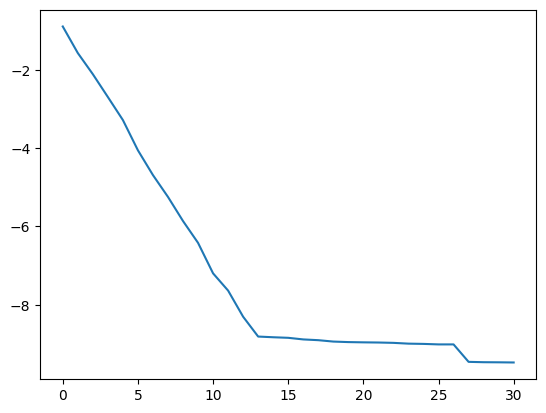

In [22]:
EE = np.array(EE).real
EE_pre = np.array(EE_pre).real
plt.plot(EE)
# plt.plot(EE_pre[1:])
# plt.plot(EE[:-1]-EE_pre[1:])

### test lanczos

In [ ]:
def lanczos(mat,k=100):
    k = min(k,mat.shape[0])

    vec = np.random.random(mat.shape[0])
    a = np.zeros(k)
    b = np.zeors(k-1)

    b0 = np.linalg.norm(vec)

    vec /= b0

    w = mat@psi

    a[0] = vec@w

    w -= a[-1]*vec

    for i in range(1,k):
        b.append()


